### Project 4 - Classification Network for ASL alphabeth recognition

This code has been written by Group 4 (Diana Nigrisoli, Ilaria Cupri, Arianna De Vecchi)

The script is organized as follows:
- Data import
- Data preparation and data exploration
    - Data Analysis
    - Calibration for analog sensors
    - Separation Train/Test sets
    - MinMax scaling for accelerometer
- Training
    - Functions and Metrics
    - Models: Classification Tres, Random Forest, KNN, LR, MLP
    

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/Lab_elettronica

/gdrive/MyDrive/Lab_elettronica


## Data import

In [16]:
# Import libraries

import pandas as pd
import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

#Import database
df = pd.read_csv('00_merged_data.csv', index_col=False)
df.shape

(2270, 12)

In [17]:
df.head(5)

,ID,mignolo,anulare,medio,indice,pollice,pres_medio,pres_pollice,x,y,z,target
0,Alejandro1_14_06_2023,26896,30485,38989,36105,31848,0,0,-243,-1465,-15449,open
1,Alejandro1_14_06_2023,18404,19926,26907,21124,28469,47032,55735,-1024,595,-15660,closed
2,Alejandro1_14_06_2023,29899,34165,40991,38633,30070,0,0,7404,13772,-3808,dummy
3,Alejandro1_14_06_2023,19249,19784,27164,22263,30187,20479,0,1619,-1068,-15443,A
4,Alejandro1_14_06_2023,29841,34859,43393,40502,28840,26496,0,243,-3833,-15097,B


In [18]:
df.columns

Index(['ID', 'mignolo', 'anulare', 'medio', 'indice', 'pollice', 'pres_medio',
       'pres_pollice', 'x', 'y', 'z', 'target'],
      dtype='object')

## Data preparation and data exploration

### Data Analysis

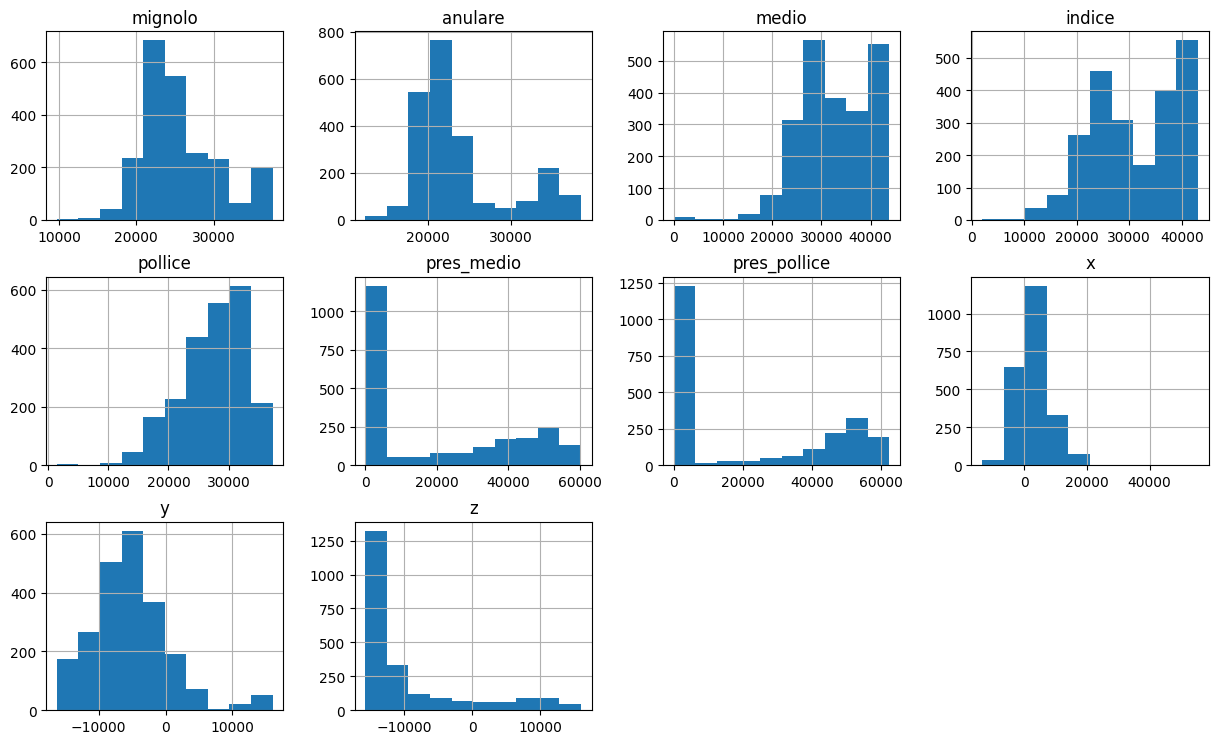

In [19]:
#HISTOGRAMS
f_hist=df.hist(layout=(4,4), figsize=(15,12))

{'whiskers': [<matplotlib.lines.Line2D at 0x78593b6ea920>,
 'caps': [<matplotlib.lines.Line2D at 0x78593b6eae60>,
 'boxes': [<matplotlib.lines.Line2D at 0x78593b6ea680>],
 'medians': [<matplotlib.lines.Line2D at 0x78593b6eb3a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x78593b6eb640>],
 'means': []}

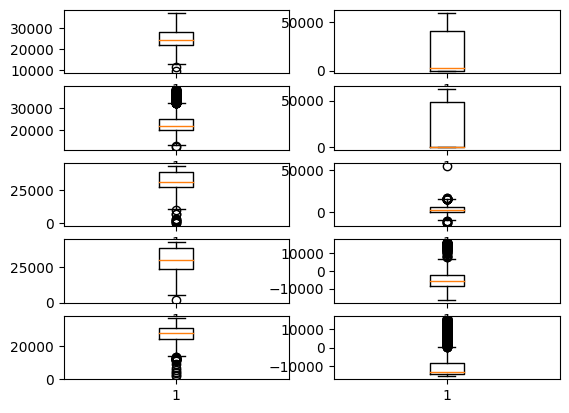

In [20]:
#BOXPLOTS
fig, axs = plt.subplots(5, 2)

axs[0, 0].boxplot(x=df['mignolo'])
axs[1, 0].boxplot(x=df['anulare'])
axs[2, 0].boxplot(x=df['medio'])
axs[3, 0].boxplot(x=df['indice'])
axs[4, 0].boxplot(x=df['pollice'])
axs[0, 1].boxplot(x=df['pres_medio'])
axs[1, 1].boxplot(x=df['pres_pollice'])
axs[2, 1].boxplot(x=df['x'])
axs[3, 1].boxplot(x=df['y'])
axs[4, 1].boxplot(x=df['z'])

### Calibration for analog sensors


In [21]:
pd.options.mode.chained_assignment = None  # default='warn'

In [22]:
new_min= -1
new_max = 1


unique_ids = df['ID'].unique().tolist()

for id in unique_ids:

    temp_df = df.loc[df['ID']==id]

    open = temp_df[['mignolo', 'anulare', 'medio', 'indice', 'pollice', 'pres_medio', 'pres_pollice']].loc[temp_df['target']=='open'].values #max
    closed = temp_df[['mignolo', 'anulare', 'medio', 'indice', 'pollice', 'pres_medio', 'pres_pollice']].loc[temp_df['target']=='closed'].values #min

    values_to_correct = temp_df[['mignolo', 'anulare', 'medio', 'indice', 'pollice', 'pres_medio', 'pres_pollice']].loc[~temp_df['target'].isin(['open', 'closed'])]

    values_corrected= (values_to_correct - closed)*(new_max - new_min) / (open-closed) + new_min #da decidere insieme

    temp_df.loc[~temp_df['target'].isin(['open', 'closed']),['mignolo', 'anulare', 'medio', 'indice', 'pollice', 'pres_medio', 'pres_pollice']] = values_corrected.values

    df.loc[df['ID']==id] = temp_df


In [23]:
df.head(10)

,ID,mignolo,anulare,medio,indice,pollice,pres_medio,pres_pollice,x,y,z,target
0,Alejandro1_14_06_2023,26896.000000,30485.000000,38989.000000,36105.000000,31848.000000,0.000000,0.000000,-243,-1465,-15449,open
1,Alejandro1_14_06_2023,18404.000000,19926.000000,26907.000000,21124.000000,28469.000000,47032.000000,55735.000000,-1024,595,-15660,closed
2,Alejandro1_14_06_2023,1.707254,1.697036,1.331402,1.337494,-0.052382,1.000000,1.000000,7404,13772,-3808,dummy
3,Alejandro1_14_06_2023,-0.800989,-1.026896,-0.957457,-0.847941,0.016869,0.129146,1.000000,1619,-1068,-15443,A
4,Alejandro1_14_06_2023,1.693594,1.828488,1.729018,1.587010,-0.780408,-0.126722,1.000000,243,-3833,-15097,B
5,Alejandro1_14_06_2023,-0.225624,-0.897528,-0.694587,-0.504038,-2.410476,1.000000,1.000000,-3225,1075,-15123,C
6,Alejandro1_14_06_2023,0.053698,-0.316223,-0.316173,1.491823,-0.001480,-1.095807,-0.982812,857,3692,-14982,D
7,Alejandro1_14_06_2023,-0.620113,-1.032011,-1.254097,-0.925506,-2.113347,1.000000,1.000000,-2073,-3545,-15161,E
8,Alejandro1_14_06_2023,1.994583,0.963822,1.655521,-0.522462,0.104469,1.000000,-1.008899,-236,-4614,-14713,F
9,Alejandro1_14_06_2023,-0.338436,-0.915712,-0.927330,1.488619,-0.646049,1.000000,-0.142298,5414,-7820,-12876,G


In [24]:
#Remove the open and close targets
df= df[~df['target'].isin(['closed', 'open'])]

df.head(10)

,ID,mignolo,anulare,medio,indice,pollice,pres_medio,pres_pollice,x,y,z,target
2,Alejandro1_14_06_2023,1.707254,1.697036,1.331402,1.337494,-0.052382,1.000000,1.000000,7404,13772,-3808,dummy
3,Alejandro1_14_06_2023,-0.800989,-1.026896,-0.957457,-0.847941,0.016869,0.129146,1.000000,1619,-1068,-15443,A
4,Alejandro1_14_06_2023,1.693594,1.828488,1.729018,1.587010,-0.780408,-0.126722,1.000000,243,-3833,-15097,B
5,Alejandro1_14_06_2023,-0.225624,-0.897528,-0.694587,-0.504038,-2.410476,1.000000,1.000000,-3225,1075,-15123,C
6,Alejandro1_14_06_2023,0.053698,-0.316223,-0.316173,1.491823,-0.001480,-1.095807,-0.982812,857,3692,-14982,D
7,Alejandro1_14_06_2023,-0.620113,-1.032011,-1.254097,-0.925506,-2.113347,1.000000,1.000000,-2073,-3545,-15161,E
8,Alejandro1_14_06_2023,1.994583,0.963822,1.655521,-0.522462,0.104469,1.000000,-1.008899,-236,-4614,-14713,F
9,Alejandro1_14_06_2023,-0.338436,-0.915712,-0.927330,1.488619,-0.646049,1.000000,-0.142298,5414,-7820,-12876,G
10,Alejandro1_14_06_2023,-0.053933,-0.141017,1.500083,1.685135,-0.154780,-0.206030,0.089369,12211,-1478,-9996,H
11,Alejandro1_14_06_2023,2.028968,-0.831613,-0.629697,-0.732461,-1.232613,1.000000,-0.928124,697,2713,-15347,I


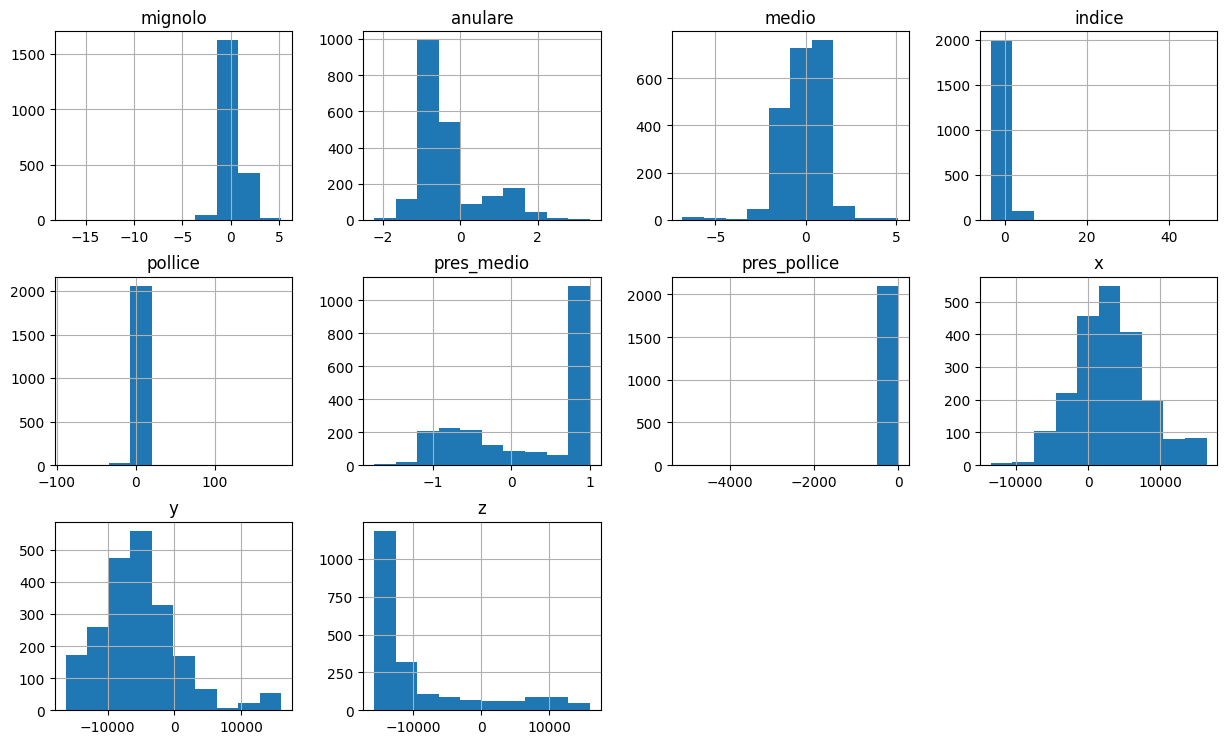

In [26]:
#Analysis after calibration
#HISTOGRAMS
f_hist=df.hist(layout=(4,4), figsize=(15,12))

### Separation Train/Test sets


In [27]:
unique_ids = df['ID'].unique().tolist()
print(unique_ids)


['Alejandro1_14_06_2023', 'Alejandro2_14_06_2023', 'Alessandro1_14_06_2023', 'Alessandro2_14_06_2023', 'AlessandroS1_14_06_2023', 'AlessandroS2_14_06_2023', 'Alice1_01_06_2023', 'Andrea1_21_06_2023', 'Anouk01_22_06_2023', 'Anouk2_22_06_2023', 'Arianna1_18_06_2023', 'Arianna1_20_06_2023', 'Arianna1_31_05_2023', 'Arianna2_18_06_2023', 'Arianna2_20_06_2023', 'Arianna2_31_05_2023', 'Arianna3_20_06_2023', 'Arianna3_31_05_2023', 'Arianna4_20_06_2023', 'Arianna5_20_06_2023', 'Davide1_01_06_2023', 'Davide2_01_06_2023', 'Diana1_14_06_2023', 'Diana1_18_07_2023', 'Diana1_19_07_2023', 'Diana1_21_06_2023', 'Diana1_21_07_2023', 'Diana1_31_05_2023', 'Diana2_14_06_2023', 'Diana2_21_06_2023', 'Diana2_21_07_2023', 'Diana2_31_05_2023', 'Federica1_01_06_2023', 'Federica2_01_06_2023', 'Giulia1_07_06_2023', 'Giulia2_07_06_2023', 'Ilaria10_14_06_2023', 'Ilaria10_15_07_2023', 'Ilaria1_01_06_2023', 'Ilaria1_04_07_2023', 'Ilaria1_07_06_2023', 'Ilaria1_14_06_2023', 'Ilaria1_15_07_2023', 'Ilaria1_31_05_2023', 'Il

In [28]:
import random
subset_size = int(len(unique_ids) * 0.75)

# Randomly select the 75% subset
random.seed(42)
subset_75 = random.sample(unique_ids, subset_size)

# Get the remaining elements as the 25% subset
subset_25 = [e for e in unique_ids if e not in subset_75]

print(subset_75)
print(subset_25)

['Arianna2_20_06_2023', 'Alessandro2_14_06_2023', 'Giulia2_07_06_2023', 'Diana2_31_05_2023', 'Diana2_14_06_2023', 'Arianna3_31_05_2023', 'Arianna2_18_06_2023', 'Ilaria8_15_07_2023', 'Arianna1_20_06_2023', 'Ilaria4_14_06_2023', 'AlessandroS1_14_06_2023', 'Miriam1_14_06_2023', 'Ilaria9_04_07_2023', 'Diana1_31_05_2023', 'Diana2_21_06_2023', 'Ilaria8_04_07_2023', 'Matteo2_14_06_2023', 'Arianna1_31_05_2023', 'Ilaria2_07_06_2023', 'Ilaria1_14_06_2023', 'Ilaria2_04_07_2023', 'Giulia1_07_06_2023', 'Diana1_21_07_2023', 'Miriam2_14_06_2023', 'Martina2_07_06_2023', 'Ilaria10_15_07_2023', 'Martina1_07_06_2023', 'Ilaria3_15_07_2023', 'Alejandro1_14_06_2023', 'Ilaria3_04_07_2023', 'Arianna1_18_06_2023', 'Ilaria5_14_06_2023', 'Ilaria7_14_06_2023', 'Davide2_01_06_2023', 'Ilaria4_04_07_2023', 'Anouk2_22_06_2023', 'Ilaria9_15_07_2023', 'Ilaria6_04_07_2023', 'Alice1_01_06_2023', 'AlessandroS2_14_06_2023', 'Diana1_19_07_2023', 'Ilaria1_07_06_2023', 'Diana1_14_06_2023', 'Ilaria10_14_06_2023', 'Arianna3_20_

In [29]:
# #TRAIN-VALIDATION-TEST SET SPLIT
# from sklearn.model_selection import train_test_split

train_set = df[df['ID'].isin(subset_75)]
test_set = df[df['ID'].isin(subset_25)]

In [30]:
train_set.head()

,ID,mignolo,anulare,medio,indice,pollice,pres_medio,pres_pollice,x,y,z,target
2,Alejandro1_14_06_2023,1.707254,1.697036,1.331402,1.337494,-0.052382,1.000000,1.000000,7404,13772,-3808,dummy
3,Alejandro1_14_06_2023,-0.800989,-1.026896,-0.957457,-0.847941,0.016869,0.129146,1.000000,1619,-1068,-15443,A
4,Alejandro1_14_06_2023,1.693594,1.828488,1.729018,1.587010,-0.780408,-0.126722,1.000000,243,-3833,-15097,B
5,Alejandro1_14_06_2023,-0.225624,-0.897528,-0.694587,-0.504038,-2.410476,1.000000,1.000000,-3225,1075,-15123,C
6,Alejandro1_14_06_2023,0.053698,-0.316223,-0.316173,1.491823,-0.001480,-1.095807,-0.982812,857,3692,-14982,D


In [31]:
test_set.head()

,ID,mignolo,anulare,medio,indice,pollice,pres_medio,pres_pollice,x,y,z,target
31,Alejandro2_14_06_2023,1.976843,1.254290,1.091495,1.151790,-20.389831,1.000000,1.000000,7270,13715,-4672,dummy
32,Alejandro2_14_06_2023,-1.077284,-1.279198,-1.255746,-1.233504,-73.508475,1.000000,1.000000,1465,-1516,-15180,A
33,Alejandro2_14_06_2023,1.811479,1.131924,1.050212,1.194246,76.050847,-0.413691,1.000000,2585,-3654,-15084,B
34,Alejandro2_14_06_2023,-0.306720,-0.966548,-1.018884,-0.715985,183.813559,1.000000,1.000000,-172,1081,-15513,C
35,Alejandro2_14_06_2023,-0.396221,-1.450655,-0.764456,0.921995,6.728814,1.000000,-0.495541,3360,-1177,-14988,D


In [32]:
X_train_temp = train_set[['mignolo', 'anulare', 'medio', 'indice', 'pollice', 'pres_medio','pres_pollice', 'x', 'y', 'z']]
y_train = train_set['target']

X_train_temp.head()

,mignolo,anulare,medio,indice,pollice,pres_medio,pres_pollice,x,y,z
2,1.707254,1.697036,1.331402,1.337494,-0.052382,1.000000,1.000000,7404,13772,-3808
3,-0.800989,-1.026896,-0.957457,-0.847941,0.016869,0.129146,1.000000,1619,-1068,-15443
4,1.693594,1.828488,1.729018,1.587010,-0.780408,-0.126722,1.000000,243,-3833,-15097
5,-0.225624,-0.897528,-0.694587,-0.504038,-2.410476,1.000000,1.000000,-3225,1075,-15123
6,0.053698,-0.316223,-0.316173,1.491823,-0.001480,-1.095807,-0.982812,857,3692,-14982


In [33]:
X_train_temp.shape

(1586, 10)

In [34]:
y_train.isna().sum()

0

In [35]:
X_test_temp = test_set[['mignolo', 'anulare', 'medio', 'indice', 'pollice', 'pres_medio','pres_pollice', 'x', 'y', 'z']]
y_test = test_set['target']

X_test_temp.head()

,mignolo,anulare,medio,indice,pollice,pres_medio,pres_pollice,x,y,z
31,1.976843,1.254290,1.091495,1.151790,-20.389831,1.000000,1.000000,7270,13715,-4672
32,-1.077284,-1.279198,-1.255746,-1.233504,-73.508475,1.000000,1.000000,1465,-1516,-15180
33,1.811479,1.131924,1.050212,1.194246,76.050847,-0.413691,1.000000,2585,-3654,-15084
34,-0.306720,-0.966548,-1.018884,-0.715985,183.813559,1.000000,1.000000,-172,1081,-15513
35,-0.396221,-1.450655,-0.764456,0.921995,6.728814,1.000000,-0.495541,3360,-1177,-14988


### MinMax scaling for accelerometer


In [36]:
from sklearn.preprocessing import MinMaxScaler

new_min= -1
new_max = 1

X_train_acc = X_train_temp[['x', 'y', 'z']]

X_test_acc = X_test_temp[['x', 'y', 'z']]

scaler = MinMaxScaler(feature_range=(new_min, new_max))
scaler.fit(X_train_acc)

X_train_acc_norm = pd.DataFrame(scaler.transform(X_train_acc))
X_train_acc_norm.columns = X_train_acc.columns

X_test_acc_norm = pd.DataFrame(scaler.transform(X_test_acc))
X_test_acc_norm.columns = X_test_acc.columns

X_train_acc_norm.shape

(1586, 3)

In [38]:
#Save the scaler
import joblib
filename = 'scaler_acc.sav'
joblib.dump(scaler, filename)

['scaler_acc.sav']

In [37]:
X_train_analog= X_train_temp[['mignolo', 'anulare', 'medio', 'indice', 'pollice', 'pres_medio','pres_pollice']]
X_test_analog= X_test_temp[['mignolo', 'anulare', 'medio', 'indice', 'pollice', 'pres_medio','pres_pollice']]

X_train_analog.shape

(1586, 7)

In [39]:
X_train=pd.concat([X_train_analog.reset_index(drop=True), X_train_acc_norm.reset_index(drop=True)], axis = 1)
X_train.shape

(1586, 10)

In [40]:
X_test=pd.concat([X_test_analog.reset_index(drop=True), X_test_acc_norm.reset_index(drop=True)], axis = 1)
X_test.head(5)

,mignolo,anulare,medio,indice,pollice,pres_medio,pres_pollice,x,y,z
0,1.976843,1.254290,1.091495,1.151790,-20.389831,1.000000,1.000000,0.368534,0.856020,-0.297173
1,-1.077284,-1.279198,-1.255746,-1.233504,-73.508475,1.000000,1.000000,-0.033976,-0.090446,-0.966921
2,1.811479,1.131924,1.050212,1.194246,76.050847,-0.413691,1.000000,0.043683,-0.223303,-0.960802
3,-0.306720,-0.966548,-1.018884,-0.715985,183.813559,1.000000,1.000000,-0.147483,0.070934,-0.988145
4,-0.396221,-1.450655,-0.764456,0.921995,6.728814,1.000000,-0.495541,0.097421,-0.069380,-0.954683


In [41]:
X_train.shape

(1586, 10)

In [42]:
y_train.shape

(1586,)

## Training
All models are evaluated through a gridserach approach, with 5 folds of cross validation.


### Functions & Metrics

In [43]:
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report



def hyperp_search(classifier, parameters):

    from sklearn.metrics import make_scorer
    f1 = make_scorer(f1_score, average='weighted')

    gs = GridSearchCV(classifier, parameters, cv=5, scoring = f1, verbose=90, n_jobs=-1)
    gs = gs.fit(X_train.values, y_train)
    print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))

    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test.values)
    y_pred_train = best_model.predict(X_train.values)

    print("f1      train %.3f   test %.3f" % (f1_score(y_train, y_pred_train, average='weighted'), f1_score(y_test, y_pred, average='weighted')))
    #print("precision  train %.3f   test %.3f" % (precision_score(y_train, y_pred_train), precision_score(y_test, y_pred) ))
    print("")
    #print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    label = ['A', 'B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','dummy']

    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, xticklabels=label, yticklabels=label)
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

    return gs.best_params_

### Classification Tree GridSearch

Fitting 5 folds for each of 96 candidates, totalling 480 fits
f1_train: 0.709698 using {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 7}
f1      train 0.820   test 0.765

              precision    recall  f1-score   support

           A       0.87      0.65      0.74        20
           B       1.00      0.95      0.97        20
           C       0.67      0.70      0.68        20
           D       0.74      0.85      0.79        20
           E       0.57      0.65      0.60        20
           F       0.85      0.85      0.85        20
           G       0.46      0.55      0.50        20
           H       0.73      0.80      0.76        20
           I       0.89      0.85      0.87        20
           J       0.79      0.75      0.77        20
           K       0.95      0.90      0.92        20
           L       0.67      0.80      0.73        20
           M       1.00      0.89      0.94        19
           N       0.90      0.95 

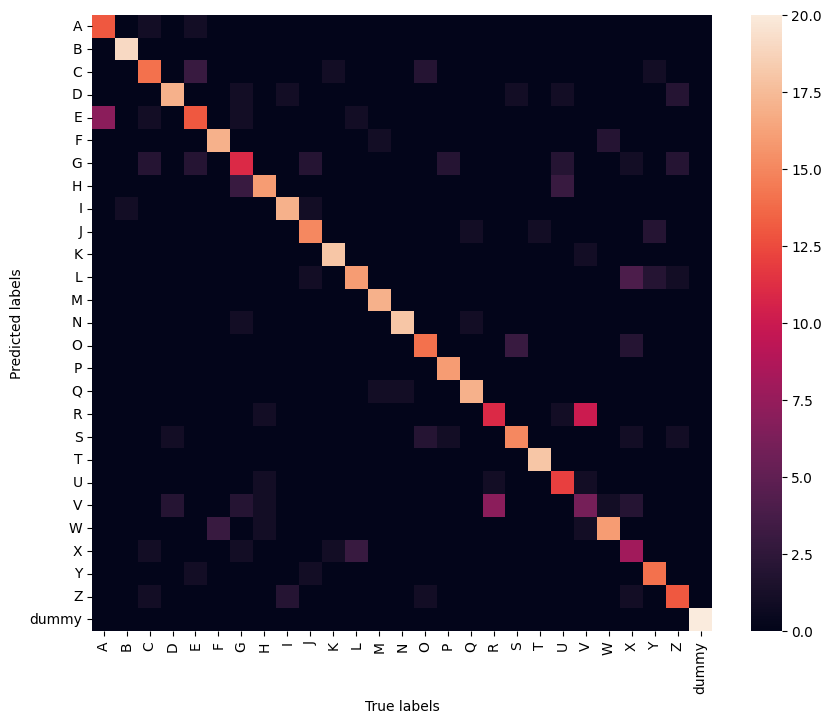

In [45]:
#Classification Trees

from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 'max_depth': [6,8,9], 'min_samples_split': [5,6,7,8], 'min_samples_leaf': [5,6,7,8]}

best_param1 = hyperp_search(classifier,parameters)

In [ ]:
#PLOT TREE
from sklearn import tree
r = tree.export_text(model_tree,feature_names=X_test.columns.tolist(),max_depth=10)
print(r)

###Random Forest GridSearch

Fitting 5 folds for each of 144 candidates, totalling 720 fits
f1_train: 0.788321 using {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 150}
f1      train 0.900   test 0.835

              precision    recall  f1-score   support

           A       0.78      0.70      0.74        20
           B       1.00      1.00      1.00        20
           C       0.75      0.75      0.75        20
           D       0.63      0.95      0.76        20
           E       0.60      0.75      0.67        20
           F       0.94      0.80      0.86        20
           G       0.93      0.65      0.76        20
           H       1.00      0.95      0.97        20
           I       0.90      0.90      0.90        20
           J       0.86      0.90      0.88        20
           K       0.91      1.00      0.95        20
           L       0.89      0.85      0.87        20
           M       1.00      0.95      0.97        19
          

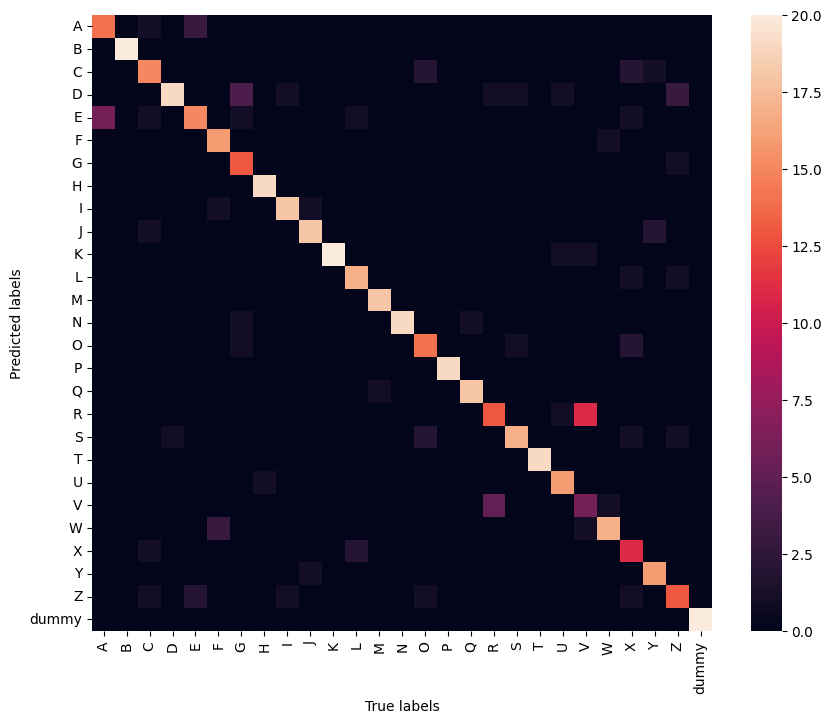

In [47]:
#RF
from sklearn.ensemble import RandomForestClassifier

classifier=RandomForestClassifier()

parameters = {'n_estimators' : [100,150],
    'criterion' : ['entropy', 'gini'],
             'max_depth' : [4,6,10,12],
             'min_samples_split' : [8,10,12],
              'min_samples_leaf' : [3,5,8]
             }

best_param7=hyperp_search(classifier,parameters)

In [52]:
model_RF = RandomForestClassifier(**best_param7)
model_RF.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=12, min_samples_leaf=5,
                       min_samples_split=12, n_estimators=150)

In [53]:
import joblib
filename = 'RandomForest_model.sav'
joblib.dump(model_RF, filename)

['RandomForest_model.sav']

###Adaboost

Fitting 5 folds for each of 16 candidates, totalling 80 fits
f1_train: 0.528877 using {'learning_rate': 0.5, 'n_estimators': 200}
f1      train 0.548   test 0.583

              precision    recall  f1-score   support

           A       0.50      0.05      0.09        20
           B       0.94      0.80      0.86        20
           C       0.39      0.35      0.37        20
           D       0.17      0.05      0.08        20
           E       0.25      0.75      0.38        20
           F       1.00      0.80      0.89        20
           G       0.33      0.35      0.34        20
           H       0.62      0.50      0.56        20
           I       1.00      0.35      0.52        20
           J       0.44      0.85      0.58        20
           K       0.95      0.95      0.95        20
           L       0.83      0.75      0.79        20
           M       1.00      0.95      0.97        19
           N       0.86      0.95      0.90        19
           O       0.43  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


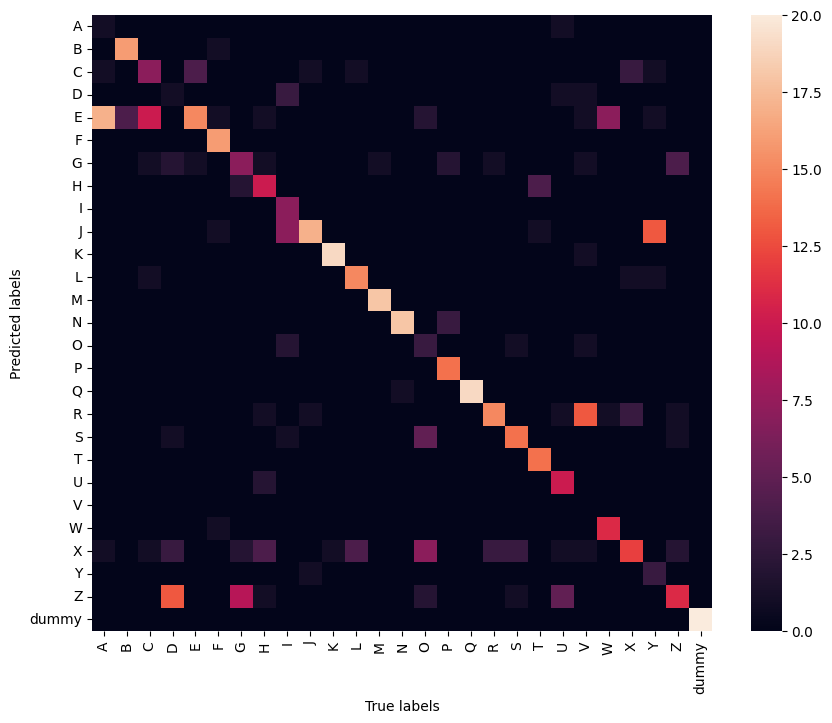

In [48]:
#AB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

classifier= AdaBoostClassifier()
parameters = {'n_estimators' : [150, 180, 200, 220],
    'learning_rate' : [0.1, 0.5, 1, 5]}

best_param8=hyperp_search(classifier,parameters)

###KNN GridSearch

Fitting 5 folds for each of 3 candidates, totalling 15 fits
f1_train: 0.640657 using {'n_neighbors': 10}
f1      train 0.713   test 0.700

              precision    recall  f1-score   support

           A       0.58      0.70      0.64        20
           B       1.00      0.90      0.95        20
           C       0.38      0.65      0.48        20
           D       0.60      0.75      0.67        20
           E       0.58      0.70      0.64        20
           F       0.94      0.75      0.83        20
           G       0.50      0.45      0.47        20
           H       0.80      0.60      0.69        20
           I       0.89      0.85      0.87        20
           J       0.82      0.90      0.86        20
           K       0.69      0.90      0.78        20
           L       0.35      0.65      0.46        20
           M       1.00      0.89      0.94        19
           N       0.94      0.89      0.92        19
           O       0.65      0.58      0.61       

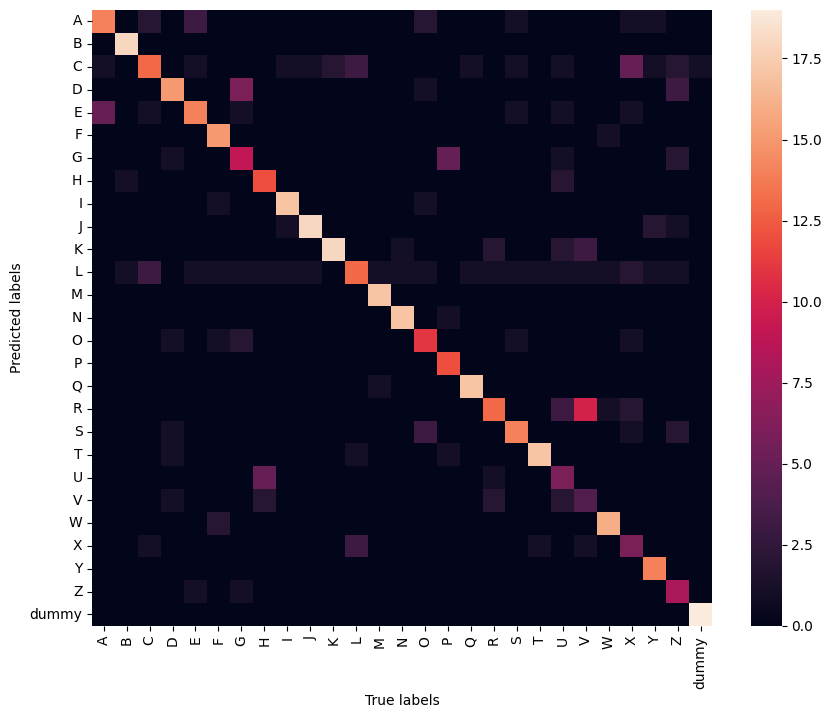

In [49]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()
parameters = {'n_neighbors': [18,50,10]}

best_param1=hyperp_search(classifier,parameters)

### LR GridSearch

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


f1_train: 0.667193 using {'C': 5, 'max_iter': 600}
f1      train 0.707   test 0.720

              precision    recall  f1-score   support

           A       0.54      0.70      0.61        20
           B       0.74      0.70      0.72        20
           C       0.81      0.65      0.72        20
           D       0.60      0.75      0.67        20
           E       0.65      0.75      0.70        20
           F       0.80      0.80      0.80        20
           G       0.91      0.50      0.65        20
           H       0.66      0.95      0.78        20
           I       0.95      0.90      0.92        20
           J       0.81      0.85      0.83        20
           K       0.59      0.95      0.73        20
           L       0.71      0.85      0.77        20
           M       0.94      0.89      0.92        19
           N       0.75      0.95      0.84        19
           O       0.80      0.63      0.71        19
           P       0.89      0.84      0.86       

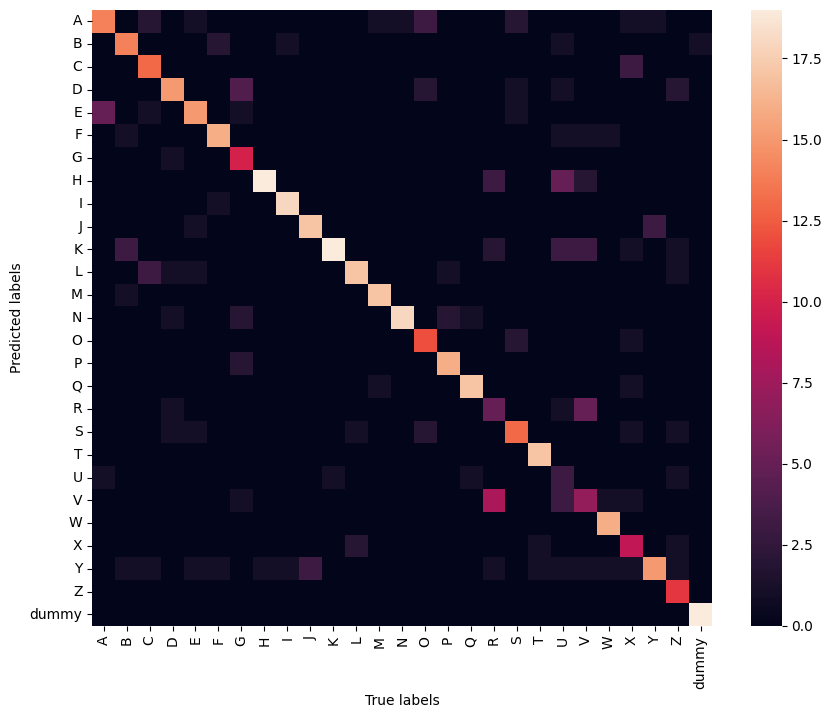

In [50]:
# Logistic
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
parameters = {"C":[1,2,5,10], "max_iter":[300,500,600] }
#paramter C: high value might lead to overfitting, while a low value is related to a more generalization capability

best_param4=hyperp_search(classifier,parameters)

###MLP GridSearch

Fitting 5 folds for each of 4 candidates, totalling 20 fits
f1_train: 0.678363 using {'alpha': 0.1, 'hidden_layer_sizes': (100, 20, 5), 'max_iter': 2000}
f1      train 0.865   test 0.770

              precision    recall  f1-score   support

           A       0.71      0.75      0.73        20
           B       0.86      0.90      0.88        20
           C       0.65      0.55      0.59        20
           D       0.67      0.70      0.68        20
           E       0.68      0.75      0.71        20
           F       0.88      0.70      0.78        20
           G       0.88      0.70      0.78        20
           H       0.94      0.75      0.83        20
           I       0.95      0.90      0.92        20
           J       0.82      0.90      0.86        20
           K       0.90      0.95      0.93        20
           L       0.88      0.75      0.81        20
           M       1.00      0.89      0.94        19
           N       0.85      0.89      0.87        19
 

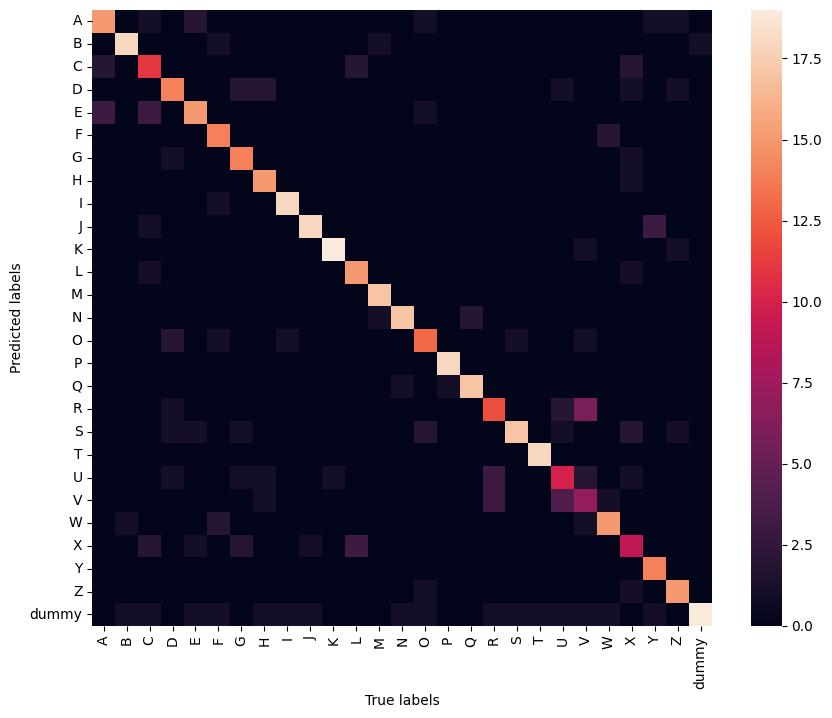

{'alpha': 0.1, 'hidden_layer_sizes': (100, 20, 5), 'max_iter': 2000}

In [51]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(10, 5),(100,20,5)],  "max_iter": [2000], "alpha": [0.001,0.1]}

hyperp_search(classifier,parameters)